In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import gseapy as gp
import statsmodels.api as sm
from adjustText import adjust_text

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# scDRS tools
import scdrs.util as util
import scdrs.data_loader as dl
import scdrs.method as md

# autoreload
%load_ext autoreload
%autoreload 2

- Set `DATA_PATH` to your local `scDRS_data_release_092121` folder
- Set `SCORE_FILE_PATH` to your local `scDRS_data_release_092121.score_file_tmsfacs` folder

In [2]:
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data_release_092121'
SCORE_FILE_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data_release_092121.score_file_tmsfacs'

## Code to reproduce main results of the paper

In [3]:
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data_release_092121'
DF_HOM = pd.read_csv(DATA_PATH+'/gene_annotation/mouse_human_homologs.txt', sep='\t')
DIC_MAP_H2M = {x:y for x,y in zip(DF_HOM['HUMAN_GENE_SYM'], DF_HOM['MOUSE_GENE_SYM'])}
DIC_MAP_M2H = {x:y for x,y in zip(DF_HOM['MOUSE_GENE_SYM'], DF_HOM['HUMAN_GENE_SYM'])}
DF_GS = pd.read_csv(DATA_PATH+'/gs_file/magma_10kb_1000.74_traits.gs', sep='\t', index_col=0)
DF_TRAIT_INFO = pd.read_csv(DATA_PATH+'/supp_table/trait_info.tsv', sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
# FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/results/fig_tcell'

# Set score file
DIC_SCORE_PATH = {'tms_facs': SCORE_FILE_PATH}

# Set trait list
TRAIT_LIST_TCELL = ['PASS_IBD_deLange2017', 'PASS_CD_deLange2017','PASS_UC_deLange2017',
                    'PASS_Rheumatoid_Arthritis', 'PASS_Multiple_sclerosis', 'UKB_460K.disease_AID_ALL',
                    'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP', 'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED',
                    'UKB_460K.disease_ASTHMA_DIAGNOSED', 'UKB_460K.disease_RESPIRATORY_ENT']

### Load data 

In [4]:
# Load TMS data 
adata = dl.load_tms_ct(DATA_PATH, data_name='facs')
adata_tcell = read_h5ad(DATA_PATH+'/single_cell_data/tms_proc/tcell.facs.annot.h5ad')

Trying to set attribute `.obs` of view, copying.


In [5]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in TRAIT_LIST_TCELL:
        file_path = DIC_SCORE_PATH[score]+'/%s.score.gz'%trait
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)       

### Analysis 

In [6]:
BACKGRD_SET = set(adata.var_names) & set(DIC_MAP_H2M.values())
GENE_LIST = sorted(BACKGRD_SET)
print('gene_list=%d, trait_list=%d'%(len(GENE_LIST), len(TRAIT_LIST_TCELL)))

# Load gold standard gene set
DF_GOLD = pd.read_csv(DATA_PATH+'/gold_standard_gs/drug_and_mendelian.tsv', sep='\t', index_col=0)
TRAIT_LIST_GOLD = list(DF_GOLD.index)
print('%d drug target gene sets mapped to %d traits: %d-%d genes'
      %(len(set(DF_GOLD.loc[~DF_GOLD['Drug_Target_Geneset'].isna(),'EFO'])), 
        (~DF_GOLD['Drug_Target_Geneset'].isna()).sum(), 
        np.min([len(x.split(',')) for x in DF_GOLD['Drug_Target_Geneset'] if type(x)==str]),
        np.max([len(x.split(',')) for x in DF_GOLD['Drug_Target_Geneset'] if type(x)==str])))
print('%d Mendelian disease gene sets mapped to %d traits: %d-%d genes'
      %(len(set(DF_GOLD.loc[~DF_GOLD['Mendelian_Geneset'].isna(),'Matched_Mendelian_Disorder'])), 
        (~DF_GOLD['Mendelian_Geneset'].isna()).sum(),
        np.min([len(x.split(',')) for x in DF_GOLD['Mendelian_Geneset'] if type(x)==str]),
        np.max([len(x.split(',')) for x in DF_GOLD['Mendelian_Geneset'] if type(x)==str])))

# Load MAGMA gene set 
DF_MAGMA = pd.read_csv(DATA_PATH+'/gene_annotation/MAGMA-v108/MAGMA_v108_GENE_10_PSTAT.txt', sep='\t')
DF_MAGMA.index = [DIC_MAP_H2M[x] if x in DIC_MAP_H2M else 'non-map' for x in DF_MAGMA.index]
DF_MAGMA = DF_MAGMA.loc[DF_MAGMA.index!='non-map'].copy()

# Cell populations
DIC_TPOP = {'all_t': list(adata_tcell.obs_names),
            'cd4_t': list(adata_tcell.obs_names[adata_tcell.obs['dpt_cd4_qn']>=0]), 
            'cd8_t': list(adata_tcell.obs_names[adata_tcell.obs['dpt_cd8_qn']>=0])}
DIC_TPOP_NAME = {'all_t': 'all T cells', 'cd4_t': 'CD4+ T cells', 'cd8_t': 'CD8+ T cells'}
for term in DIC_TPOP:
    print('%s n_cell=%d'%(term, len(DIC_TPOP[term])))

gene_list=14807, trait_list=10
27 drug target gene sets mapped to 27 traits: 10-410 genes
16 Mendelian disease gene sets mapped to 45 traits: 69-723 genes
all_t n_cell=3769
cd4_t n_cell=1686
cd8_t n_cell=2197


In [7]:
# scDRS correlation: precomputed correlation (across all cells) for 74 traits
df_corr_scdrs = pd.DataFrame(index=GENE_LIST)
for trait in TRAIT_LIST_GOLD:        
    temp_df = pd.read_csv(DATA_PATH+'/downstream_file/downstream.tms_facs_with_cov.magma_10kb_1000' 
                          '/%s.scdrs_gene'%trait, sep='\t', index_col=0)
    temp_list = sorted(BACKGRD_SET & set(temp_df.index))
    df_corr_scdrs[trait] = 0
    df_corr_scdrs.loc[temp_list, trait] = temp_df.loc[temp_list, 'CORR']

# scDRS correlation across T cells 
for tpop in DIC_TPOP:
    cell_list = DIC_TPOP[tpop].copy()    
    temp_adata = adata[cell_list, GENE_LIST].copy()
    mat_expr = temp_adata.X.toarray().copy()
    for trait in TRAIT_LIST_TCELL:        
        v_corr = md._pearson_corr(mat_expr, dic_score[score].loc[cell_list, '%s.norm_score'%trait].values)
        df_corr_scdrs['%s.%s'%(trait,tpop)] = v_corr

In [8]:
# GWAS and scDRS gene sets 
dic_gs = {}

# GWAS gene set
for trait in TRAIT_LIST_GOLD:
    dic_gs['%s.gwas'%trait] = set([DIC_MAP_H2M[x] for x in DF_GS.loc[trait, 'GENESET'].split(',') 
                                   if x in DIC_MAP_H2M]) & BACKGRD_SET
    
# scDRS gene sets       
for trait in TRAIT_LIST_GOLD:
    temp_df = df_corr_scdrs[[trait]].copy()
    temp_df.sort_values(by=[trait], ascending=False, inplace=True)
    dic_gs['%s.scdrs'%trait] = set(temp_df.index[:len(dic_gs['%s.gwas'%trait])])  

for trait in TRAIT_LIST_TCELL:
    for tpop in DIC_TPOP:    
        temp_df = df_corr_scdrs[['%s.%s'%(trait,tpop)]].copy()
        temp_df.sort_values(by=['%s.%s'%(trait,tpop)], ascending=False, inplace=True)
        dic_gs['%s.%s.scdrs'%(trait,tpop)] = set(temp_df.index[:len(dic_gs['%s.gwas'%(trait)])])
    
# T cell SEGs
tpop = 'all_t'
cell_list = DIC_TPOP[tpop].copy()
temp_adata = adata[:, GENE_LIST].copy()
temp_adata.obs['tcell'] = 'nt'
temp_adata.obs.loc[cell_list, 'tcell'] = 't'
sc.tl.rank_genes_groups(temp_adata, groupby='tcell', groups=['t'])
df_t = sc.get.rank_genes_groups_df(temp_adata, 't')
for trait in TRAIT_LIST_TCELL:     
    dic_gs['%s.%s.seg'%(trait,tpop)] = set(df_t['names'][:len(dic_gs['%s.gwas'%trait])])

# Gold standard gene set: drug targets
for trait in DF_GOLD.index[~DF_GOLD['Drug_Target_Geneset'].isna()]:
    dic_gs['%s.ref_drug'%trait] = set([DIC_MAP_H2M[x] for x in DF_GOLD.loc[trait,'Drug_Target_Geneset'].split(',')
                                       if x in DIC_MAP_H2M]) & BACKGRD_SET

# Gold standard gene set: Mendelian genes 
for trait in DF_GOLD.index[~DF_GOLD['Mendelian_Geneset'].isna()]:
    dic_gs['%s.ref_mende'%trait] = set([DIC_MAP_H2M[x] for x in DF_GOLD.loc[trait,'Mendelian_Geneset'].split(',')
                                        if x in DIC_MAP_H2M]) & BACKGRD_SET
    
# Gold standard gene set: combining the two
for trait in TRAIT_LIST_TCELL:
    if '%s.ref_drug'%trait in dic_gs:
        dic_gs['%s.ref'%trait] = dic_gs['%s.ref_drug'%trait]
        print('Drug: %s, n_gene=%d'%(trait, len(DF_GOLD.loc[trait, 'Drug_Target_Geneset'].split(','))))
    else:
        dic_gs['%s.ref'%trait] = dic_gs['%s.ref_mende'%trait]
        print('Mendelian: %s, n_gene=%d'%(trait, len(DF_GOLD.loc[trait, 'Mendelian_Geneset'].split(','))))

... storing 'tissue_celltype' as categorical
... storing 'tcell' as categorical


Drug: PASS_IBD_deLange2017, n_gene=35
Drug: PASS_CD_deLange2017, n_gene=143
Drug: PASS_UC_deLange2017, n_gene=142
Drug: PASS_Rheumatoid_Arthritis, n_gene=223
Drug: PASS_Multiple_sclerosis, n_gene=250
Drug: UKB_460K.disease_AID_ALL, n_gene=82
Mendelian: UKB_460K.disease_HYPOTHYROIDISM_SELF_REP, n_gene=550
Drug: UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED, n_gene=27
Drug: UKB_460K.disease_ASTHMA_DIAGNOSED, n_gene=123
Mendelian: UKB_460K.disease_RESPIRATORY_ENT, n_gene=550


In [9]:
# Compute stats
dic_stats = {}
compute_list = [[x,'ref'] for x in ['gwas', 'scdrs', 'all_t.scdrs', 'cd4_t.scdrs', 'cd8_t.scdrs', 'all_t.seg']]+\
                [[x, 'ref_drug'] for x in ['gwas', 'scdrs']] + [[x, 'ref_mende'] for x in ['gwas', 'scdrs']]
for res,res_ref in compute_list:
    dic_stats['%s.%s'%(res,res_ref)] = pd.DataFrame(columns=['GWAS', 'GS', 'overlap', 'excess_overlap', 
                                                             'odds_ratio', 'odds_ratio.ub', 'odds_ratio.lb',
                                                             'pval', 'nlog10pval', 'overlap_gene'], 
                                                    dtype=float)
    for trait in [x.replace('.%s'%res_ref, '') for x in dic_gs if x.endswith(res_ref)]:
        if ('%s.%s'%(trait, res) not in dic_gs):
            continue
        gs_set = dic_gs['%s.%s'%(trait, res)] & BACKGRD_SET
        gs_set_ref = dic_gs['%s.%s'%(trait, res_ref)] & BACKGRD_SET
        pvalue,oddsratio,or_ub,or_lb = util.test_overlap(gs_set, gs_set_ref, BACKGRD_SET)

        dic_stats['%s.%s'%(res,res_ref)].loc[trait,'GWAS'] = len(gs_set)
        dic_stats['%s.%s'%(res,res_ref)].loc[trait,'GS'] = len(gs_set_ref)
        dic_stats['%s.%s'%(res,res_ref)].loc[trait,'overlap'] = len(gs_set & gs_set_ref)
        excess_overlap = len(gs_set & gs_set_ref) * len(BACKGRD_SET) / len(gs_set) / len(gs_set_ref)
        dic_stats['%s.%s'%(res,res_ref)].loc[trait,'excess_overlap'] = excess_overlap
        dic_stats['%s.%s'%(res,res_ref)].loc[trait,'odds_ratio'] = oddsratio
        dic_stats['%s.%s'%(res,res_ref)].loc[trait,'odds_ratio.ub'] = or_ub
        dic_stats['%s.%s'%(res,res_ref)].loc[trait,'odds_ratio.lb'] = or_lb
        dic_stats['%s.%s'%(res,res_ref)].loc[trait,'pval'] = pvalue
        dic_stats['%s.%s'%(res,res_ref)].loc[trait,'nlog10pval'] = -np.log10(pvalue)
        dic_stats['%s.%s'%(res,res_ref)].loc[trait,'overlap_gene'] = ','.join(sorted(gs_set & gs_set_ref))

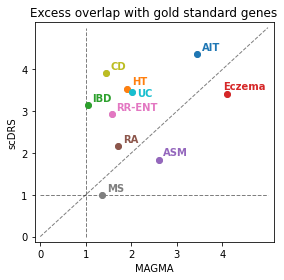

In [10]:
# Figure 
dic_name = {'gwas':'MAGMA', 'scdrs': 'scDRS', 'all_t.scdrs':'scDRS across T cells', 
            'cd4_t.scdrs':'scDRS across CD4+ T cells', 'cd8_t.scdrs':'scDRS across CD8+ T cells',
            'all_t.seg':'T cell SEGs', 'ref_drug': 'drug targets', 'ref_mende': 'Mendelian genes',
            'nlog10pval': '-log10 p-value for excess overlap', 'excess_overlap': 'Excess overlap'}
dic_config_trait = {'UKB_460K.disease_AID_ALL': ['C0'], 
                    'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP': ['C1'], 
                    'PASS_IBD_deLange2017': ['C2'], 
                    'PASS_CD_deLange2017': ['C8'], 
                    'PASS_UC_deLange2017': ['C9'], 
                    'PASS_Rheumatoid_Arthritis': ['C5'],
                    'UKB_460K.disease_RESPIRATORY_ENT': ['C6'],
                    'UKB_460K.disease_ASTHMA_DIAGNOSED': ['C4'],
                    'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED': ['C3'],
                    'PASS_Multiple_sclerosis':['C7'],
                   }

# Main Figure 
res_main,res_ref,plot_term = 'scdrs.ref','gwas.ref','excess_overlap'
plt.figure(figsize=[4,4])
trait_list = list(dic_stats[res_main].index)
plt.scatter(dic_stats[res_ref].loc[trait_list, plot_term], 
            dic_stats[res_main].loc[trait_list, plot_term], color='k', alpha=0.2, zorder=5)
for trait in dic_config_trait:
    plt.scatter(dic_stats[res_ref].loc[trait, plot_term], dic_stats[res_main].loc[trait, plot_term], 
                color=dic_config_trait[trait][0], zorder=10)
    plt.text(dic_stats[res_ref].loc[trait, plot_term]+0.1 - 
             0.2*(trait in ['UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED']), 
             dic_stats[res_main].loc[trait, plot_term]+0.1 - 0.2*(trait in ['PASS_UC_deLange2017']),
             DF_TRAIT_INFO.loc[trait, 'Code'], color=dic_config_trait[trait][0],
             weight="bold", zorder=10)
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
max_ = np.ceil(max(xmax, ymax)).astype(int)
step_ = max(1,int((max_ - 0)/5))
plt.plot([0, max_], [0, max_], '--', color='k', alpha=0.5, zorder=0, linewidth=1)
plt.plot([0, max_], [1, 1], '--', color='k', alpha=0.5, zorder=0, linewidth=1)
plt.plot([1, 1], [0, max_], '--', color='k', alpha=0.5, zorder=0, linewidth=1)
plt.xlim([-max_*0.025, max_*1.025])
plt.ylim([-max_*0.025, max_*1.025])
plt.xlabel(dic_name[res_ref.replace('.ref','')])
plt.ylabel(dic_name[res_main.replace('.ref','')])
plt.xticks(np.arange(0, max_, step_), np.arange(0, max_, step_))
plt.yticks(np.arange(0, max_, step_), np.arange(0, max_, step_))
plt.title('Excess overlap with gold standard genes')
plt.tight_layout()
# plt.savefig(FIG_PATH+'/comparison_gs_main.svg')
plt.show()

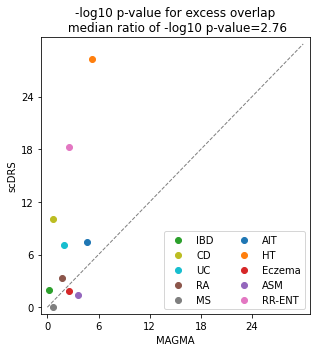

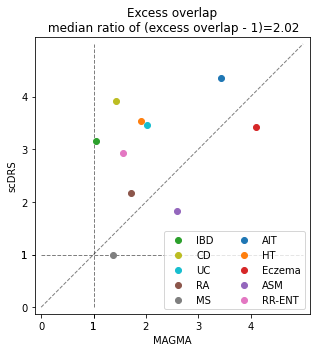

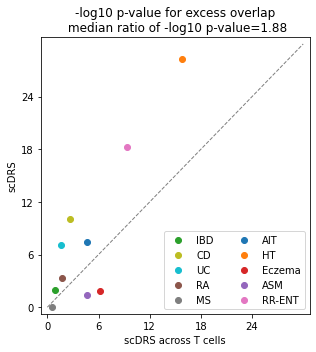

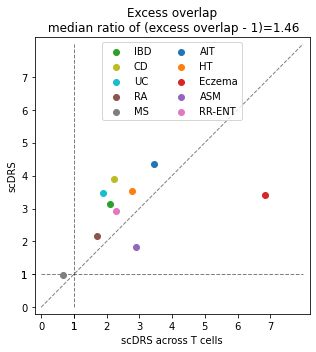

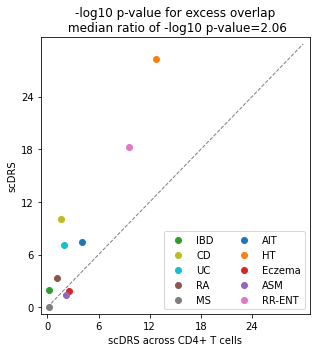

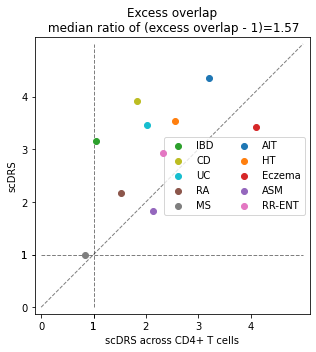

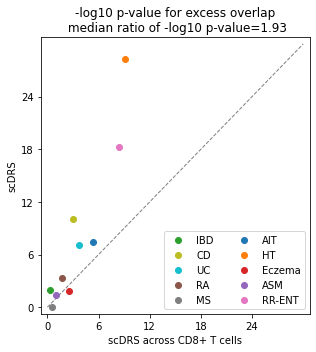

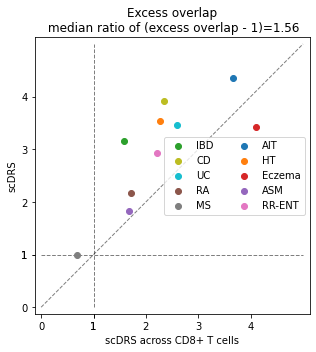

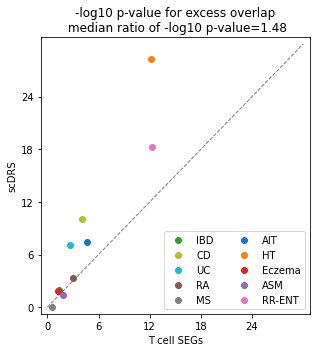

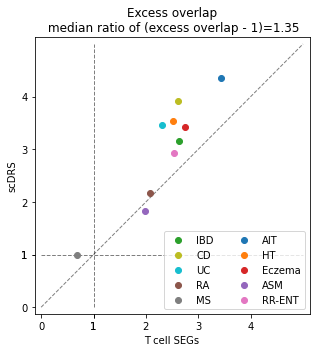

In [11]:
# All comparisons 
plot_list = []
res_main = 'scdrs.ref'    
for res_ref in [x for x in dic_stats.keys() if (x!=res_main) & (x.endswith('ref'))]:
    for term in ['nlog10pval', 'excess_overlap']:
        plot_list.append([res_ref, term])
        
for res_ref,plot_term in plot_list:
    trait_list = TRAIT_LIST_TCELL.copy()
    if plot_term=='nlog10pval':
        median_ratio = (dic_stats[res_main].loc[trait_list, plot_term] /
                        dic_stats[res_ref].loc[trait_list, plot_term]).median()   
        title_str = '%s\n median ratio of -log10 p-value=%0.2f'%(dic_name[plot_term], median_ratio)
    elif  plot_term=='excess_overlap':
        median_ratio = ((dic_stats[res_main].loc[trait_list, plot_term]-1).clip(lower=0.01) /
                        (dic_stats[res_ref].loc[trait_list, plot_term]-1).clip(lower=0.01)).median()   
        title_str = '%s\n median ratio of (excess overlap - 1)=%0.2f'%(dic_name[plot_term], median_ratio)
    else:
        median_ratio=0
    
    plt.figure(figsize=[4.5,5])
    # Supp. Figs. 
    for i_trait,trait in enumerate(trait_list):
        color_ = dic_config_trait[trait][0] if trait in dic_config_trait else 'C%d'%i_trait
        plt.scatter(dic_stats[res_ref].loc[trait, plot_term], dic_stats[res_main].loc[trait, plot_term], 
                    zorder=10, label=DF_TRAIT_INFO.loc[trait, 'Code'], color=color_)
    plt.legend(ncol=2)
    xmin,xmax = plt.xlim()
    ymin,ymax = plt.ylim()
    max_ = np.ceil(max(xmax, ymax)).astype(int)
    plt.plot([0, max_], [0, max_], '--', color='k', alpha=0.5, zorder=0, linewidth=1)
    plt.xlim([-max_*0.025, max_*1.025])
    plt.ylim([-max_*0.025, max_*1.025])
    step_ = max(1,int((max_ - 0)/5))
    tick_list = list(np.arange(0, max_, step_))
    if plot_term == 'excess_overlap':
        plt.plot([0, max_], [1, 1], '--', color='k', alpha=0.5, zorder=0, linewidth=1)
        plt.plot([1, 1], [0, max_], '--', color='k', alpha=0.5, zorder=0, linewidth=1)
        tick_list = sorted(tick_list + [1])
    plt.xticks(tick_list, tick_list)
    plt.yticks(tick_list, tick_list)
    plt.xlabel(dic_name[res_ref.replace('.ref','')])
    plt.ylabel(dic_name[res_main.replace('.ref','')])
    plt.title(title_str)
    plt.tight_layout()
#     plt.savefig(FIG_PATH+'/comparison_gs.%s.%s.svg'%(res_ref.replace('.ref','').replace('.','_'),plot_term))
    plt.show()
#     break

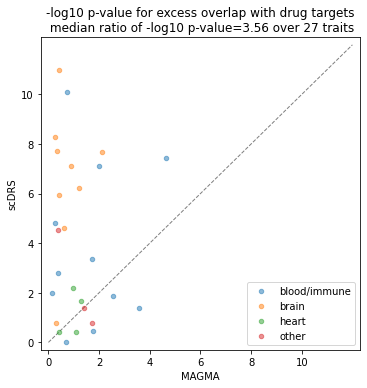

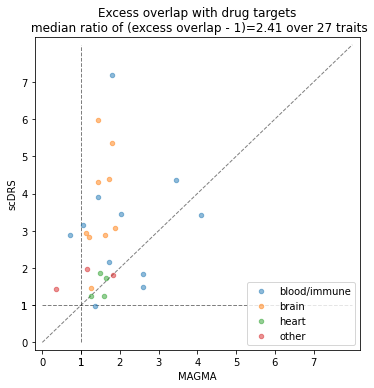

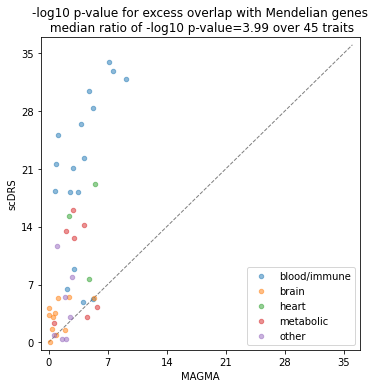

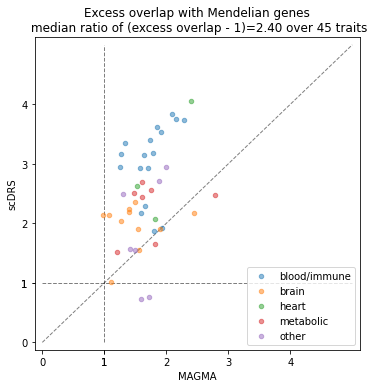

In [12]:
res_ref = 'gwas'
for gold_gs in ['ref_drug', 'ref_mende']:
    for plot_term in ['nlog10pval', 'excess_overlap']:
        trait_list = sorted(set(dic_stats['%s.%s'%(res_ref,gold_gs)].index) & 
                            set(dic_stats['scdrs.%s'%gold_gs].index))
        median_ratio = (dic_stats['scdrs.%s'%gold_gs].loc[trait_list, plot_term] /
                        dic_stats['%s.%s'%(res_ref,gold_gs)].loc[trait_list, plot_term]).median()  
        
        if plot_term=='nlog10pval':
            median_ratio = (dic_stats['scdrs.%s'%gold_gs].loc[trait_list, plot_term] /
                        dic_stats['%s.%s'%(res_ref,gold_gs)].loc[trait_list, plot_term]).median()  
            title_str = '%s with %s\n median ratio of -log10 p-value=%0.2f over %d traits'\
                %(dic_name[plot_term], dic_name[gold_gs], median_ratio, len(trait_list))
        elif  plot_term=='excess_overlap':
            median_ratio = ((dic_stats['scdrs.%s'%gold_gs].loc[trait_list, plot_term]-1).clip(lower=0.01) /
                        (dic_stats['%s.%s'%(res_ref,gold_gs)].loc[trait_list, plot_term]-1).clip(lower=0.01)).median()
            title_str = '%s with %s\n median ratio of (excess overlap - 1)=%0.2f over %d traits'\
                %(dic_name[plot_term], dic_name[gold_gs], median_ratio, len(trait_list))
        else:
            median_ratio=0

        plt.figure(figsize=[5.2,5.5])
        for cate in sorted(DF_TRAIT_INFO['Category'].unique()):
            trait_list_cate = sorted(set(trait_list) & set(DF_TRAIT_INFO.index[DF_TRAIT_INFO['Category']==cate]))
            if len(trait_list_cate)==0:
                continue
            plt.scatter(dic_stats['%s.%s'%(res_ref,gold_gs)].loc[trait_list_cate, plot_term], 
                        dic_stats['scdrs.%s'%gold_gs].loc[trait_list_cate, plot_term],
                        s=20, alpha=0.5, label=cate)
        
        # Annotate traits
        for trait in trait_list:
            x_val = dic_stats['%s.%s'%(res_ref,gold_gs)].loc[trait, plot_term]
            y_val = dic_stats['scdrs.%s'%gold_gs].loc[trait, plot_term]
            if x_val-y_val>3:
                plt.text(x_val+0.25, y_val, DF_TRAIT_INFO.loc[trait, 'Code'], 
                         color='k', weight="normal", zorder=10)
        
        xmin,xmax = plt.xlim()
        ymin,ymax = plt.ylim()
        max_ = np.ceil(max(xmax, ymax)).astype(int)
        plt.plot([0, max_], [0, max_], '--', color='k', alpha=0.5, zorder=0, linewidth=1)
        plt.xlim([-max_*0.025, max_*1.025])
        plt.ylim([-max_*0.025, max_*1.025])
        step_ = max(1, int((max_ - 0)/5))
        tick_list = list(np.arange(0, max_, step_))
        if plot_term == 'excess_overlap':
            plt.plot([0, max_], [1, 1], '--', color='k', alpha=0.5, zorder=0, linewidth=1)
            plt.plot([1, 1], [0, max_], '--', color='k', alpha=0.5, zorder=0, linewidth=1)
            tick_list = sorted(tick_list + [1])       
        plt.xticks(tick_list, tick_list)
        plt.yticks(tick_list, tick_list)
        plt.xlabel(dic_name[res_ref])
        plt.ylabel(dic_name['scdrs'])       
        plt.title(title_str)
        plt.legend(loc='lower right')
        plt.tight_layout()
#         plt.savefig(FIG_PATH+'/comparison_gs.%s.%s.svg'%(gold_gs,plot_term))
        plt.show()